In [1]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import seaborn as sns
import scipy.optimize as sco
import scipy.stats as scs
import scipy.interpolate as sci
import statsmodels.api as sm
import yfinance as yf
from datetime import datetime
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (20, 7)
mpl.rcParams['font.family'] = 'serif'

<ipython-input-1-8aa4f726b782>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# **Top 5 largest companies by market cap**

In [2]:
# Top 10 largest companies by market cap
symbols = ['AAPL', 'MSFT', 'NVDA', 'GOOG','AMZN']

# Download data from yahoo finance
end_date =  datetime.today().date()
start_date = end_date.replace(year=end_date.year - 5)
data = yf.download(symbols, start =  start_date, end = end_date).reset_index()

[*********************100%***********************]  5 of 5 completed


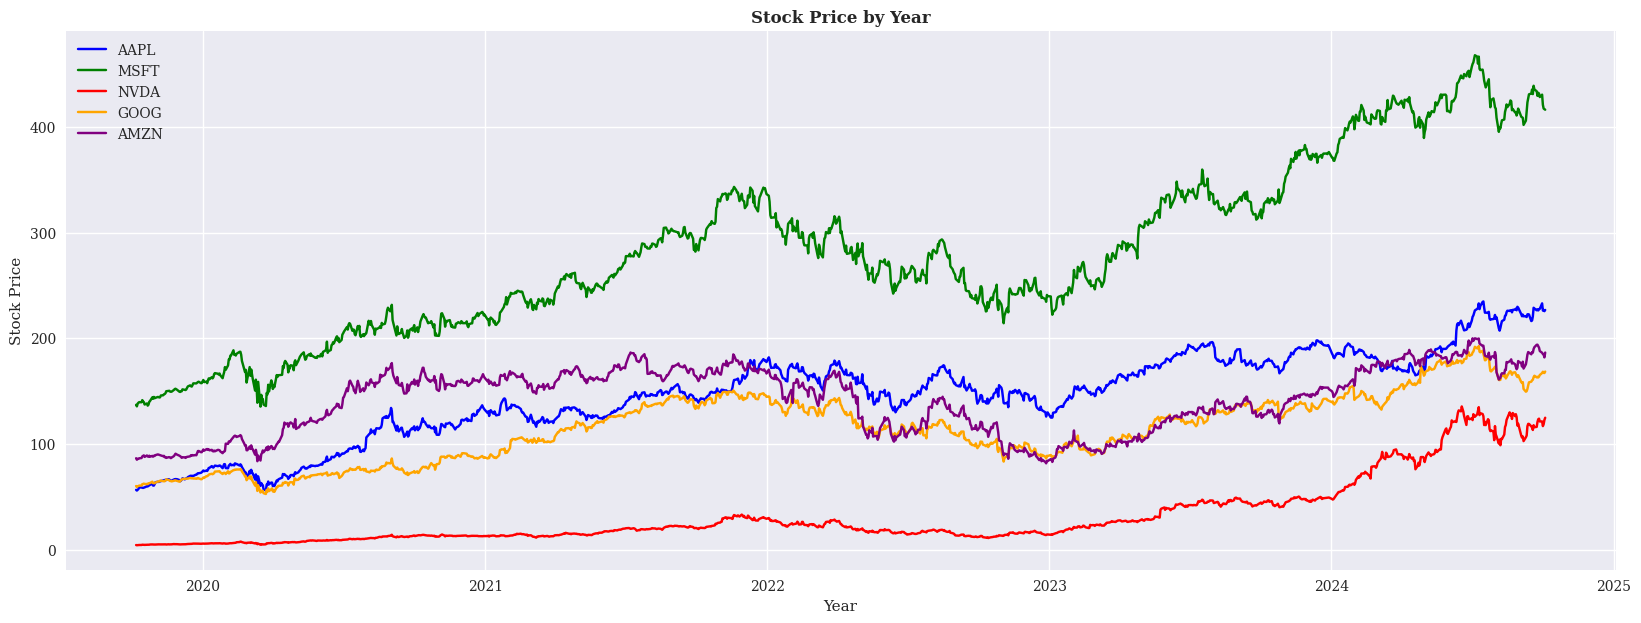

In [3]:
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, sym in enumerate(symbols):
    plt.plot(data['Date'], data['Close'][sym], label=sym, color = colors[i % len(colors)])
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Stock Price by Year', fontweight = 'bold')
plt.legend()
plt.grid(True)
plt.show()

# **Descriptive Statistics**

In [4]:
# Compute daily returns
returns = np.log(data['Close'] / data['Close'].shift(1))
returns.describe()

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,0.001102,0.000610,0.000817,0.000883,0.002625
std,0.019956,0.022399,0.020112,0.019095,0.033575
min,-0.137708,-0.151398,-0.117667,-0.159453,-0.203979
25%,-0.008269,-0.011129,-0.008876,-0.008498,-0.015777
50%,0.001254,0.000643,0.002017,0.000964,0.003286
75%,0.012195,0.012275,0.010984,0.010859,0.021850
max,0.113157,0.126949,0.094994,0.132929,0.218088


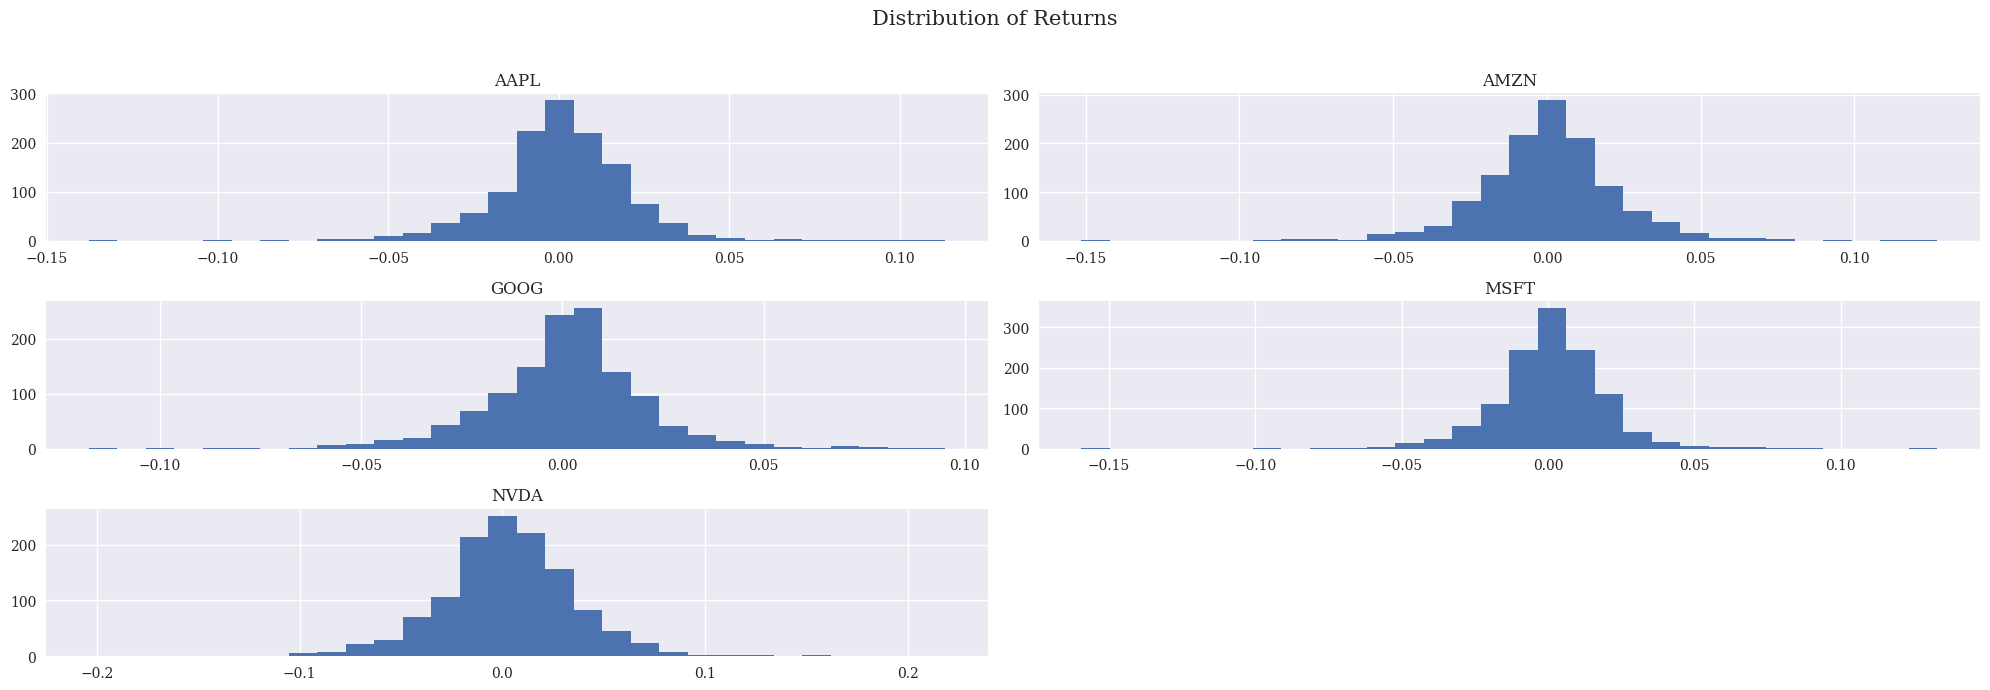

In [5]:
# Histogram
returns.hist(bins = 30)
plt.suptitle('Distribution of Returns', fontsize = 15)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# **Correlation Analysis**

Text(0.5, 1.0, 'Stocks return correlation')

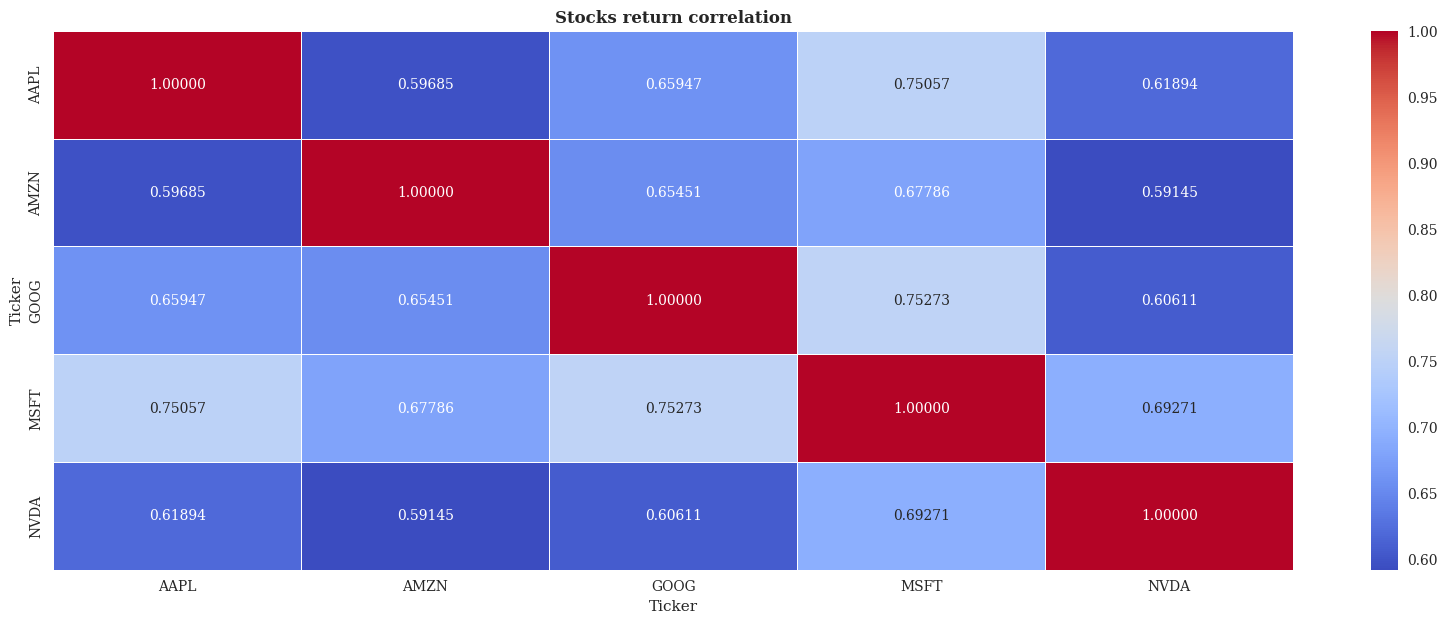

In [6]:
# Correlation Matrix
corr_matrix = returns.dropna().corr()

# Plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.5f', linewidths=0.5)
plt.title('Stocks return correlation', fontweight = 'bold')

# **Normality Test**

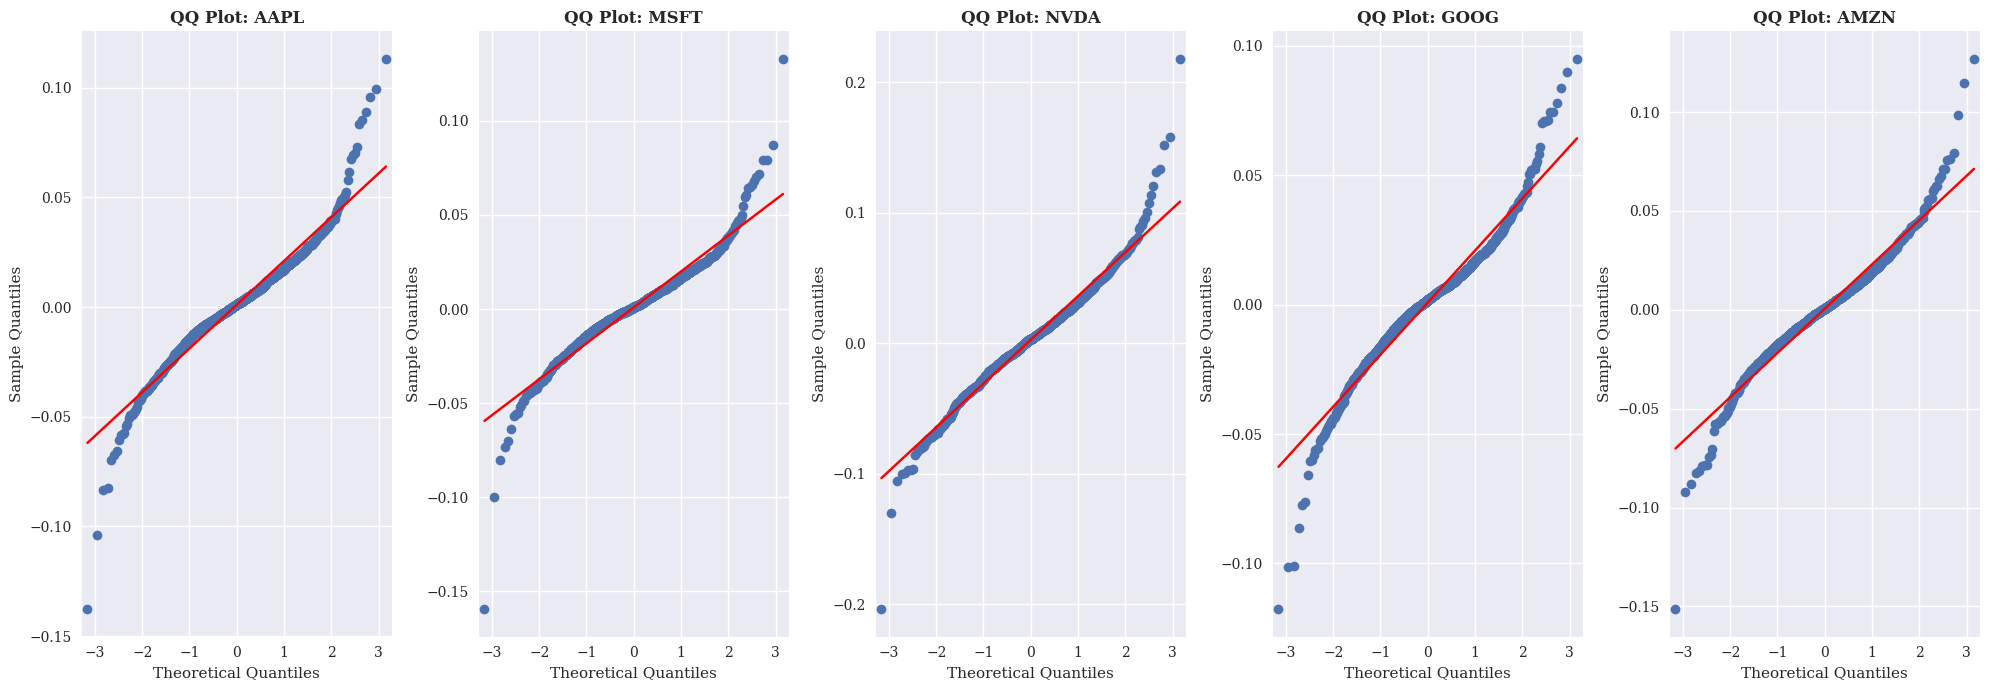

In [7]:
n = 10
ncols = 5
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 7))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# QQ plot
for i, sym in enumerate(symbols):
    sm.qqplot(returns[sym].dropna(), line='s', ax=axes[i])
    axes[i].set_title(f'QQ Plot: {sym}', fontsize=12, fontweight = 'bold')
    axes[i].set_xlabel('Theoretical Quantiles')
    axes[i].set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

In [8]:
def normality_test(arr):
  print('Skew value is: ', scs.skew(arr))
  print('Skew test p-value: ', scs.skewtest(arr)[1])
  print('Kurtosis value is: ', scs.kurtosis(arr))
  print('Kurtosis test p-value: ', scs.kurtosistest(arr)[1])
  print('Normality test p-value: ', scs.normaltest(arr)[1])

In [9]:
for sym in symbols:
  print('\n Result for symbol {}'.format(sym))
  print(32 * '-')
  returns_data = np.array(returns[sym].dropna())
  normality_test(returns_data)


 Result for symbol AAPL
--------------------------------
Skew value is:  -0.12216612936939171
Skew test p-value:  0.07636251253622539
Kurtosis value is:  5.337661579269712
Kurtosis test p-value:  3.8077758777023224e-35
Normality test p-value:  1.2356623961188564e-34

 Result for symbol MSFT
--------------------------------
Skew value is:  -0.26616242275173146
Skew test p-value:  0.00013857890991736838
Kurtosis value is:  7.708689398964898
Kurtosis test p-value:  7.684096193607373e-45
Normality test p-value:  9.555047552439317e-47

 Result for symbol NVDA
--------------------------------
Skew value is:  0.12965276015453098
Skew test p-value:  0.0601160790776106
Kurtosis value is:  3.554319014340712
Kurtosis test p-value:  1.205018901496436e-25
Normality test p-value:  2.725075060465086e-25

 Result for symbol GOOG
--------------------------------
Skew value is:  -0.2632470425718436
Skew test p-value:  0.00016306438034217852
Kurtosis value is:  3.9701272445323728
Kurtosis test p-value: 

# **Modern Portfolio Theory**

In [10]:
rets_mean = returns.mean() * 252 # Annualized mean returns
rets_cov = returns.cov() * 252 # Annualized covariance returns

In [11]:
# Number of assets
noa = len(symbols)

# Define func for portfolio expected returns and variance
def port_mean(weights):
  return np.sum(weights * rets_mean)

def port_var(weights):
  return np.sqrt(np.dot(weights.T, np.dot(weights, rets_cov)))

In [12]:
port_returns = []
port_vol = []

# Simulate weights
for i in range(2500):
  weights = np.random.random(noa)
  weights = weights / np.sum(weights)
  port_returns.append(port_mean(weights))
  port_vol.append(port_var(weights))
port_returns = np.array(port_returns)
port_vol = np.array(port_vol)

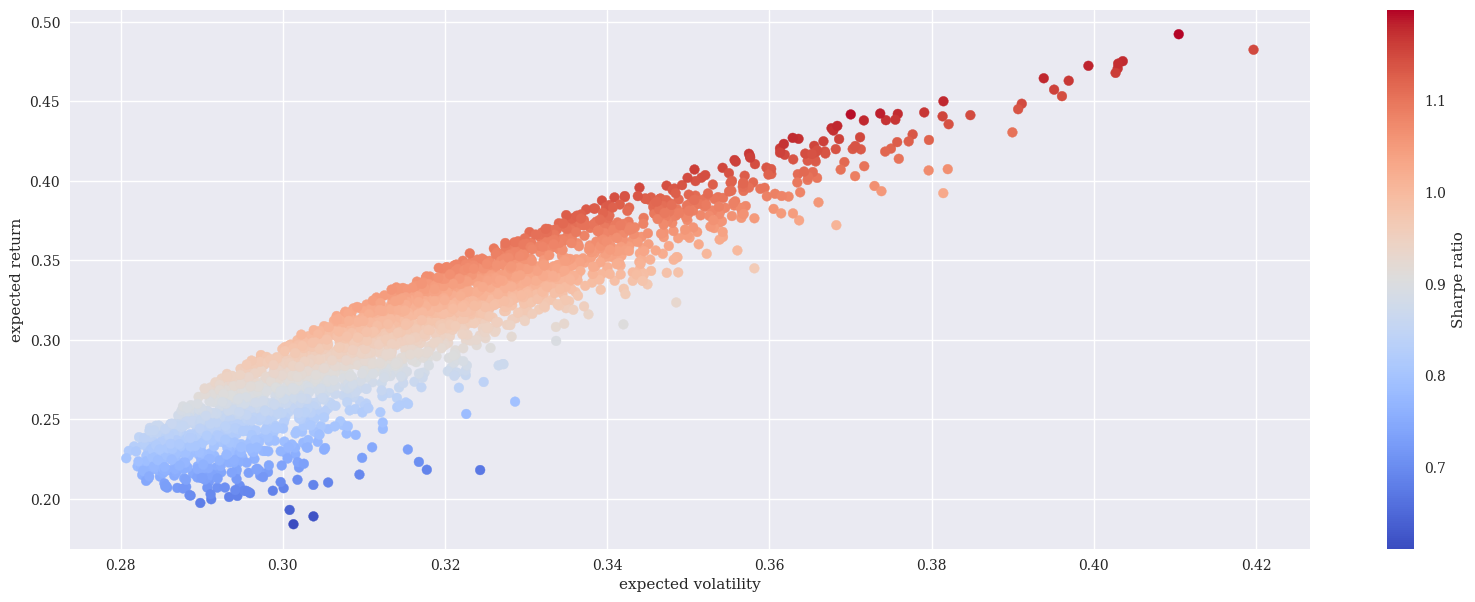

In [13]:
# Efficient Frontier
plt.scatter(port_vol, port_returns, c=port_returns / port_vol,
marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

# **Optimal Portfolio**

**Maximum sharpe ratio**

In [14]:
# Max sharpe ratio
def max_sharpe(weights):
  return -port_mean(weights) / port_var(weights)

bounds = tuple((0, 1) for x in range(noa))     # Bounds for optimization
cons =  ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})    # Constraints
eweights = np.array(noa * [1. / noa])   # Generate equal weighted values initially.

# Optimization
opt_sharpe =  sco.minimize(max_sharpe, eweights, method = 'SLSQP', bounds = bounds, constraints = cons)
# Weighted values for max sharpe ratio portfolio:
print('The weighted value is:', opt_sharpe['x'])
print('Sharpe ratio for this portfolio is:', port_mean(opt_sharpe['x'] / port_var(opt_sharpe['x'])))

The weighted value is: [2.07342016e-01 0.00000000e+00 4.09828421e-17 2.51534904e-17
 7.92657984e-01]
Sharpe ratio for this portfolio is: 1.2488461824860275


**Minimum volatility**

In [15]:
# Optimization
opt_vol =  sco.minimize(port_var, eweights, method = 'SLSQP', bounds = bounds, constraints = cons)
# Weighted values for volatility for this portfolio:
print('The weighted value is:', opt_vol['x'])
print('The volatility for this portfolio is:', port_var(opt_vol['x']))

The weighted value is: [3.01682591e-01 1.30798942e-01 2.54660677e-01 3.12857789e-01
 1.51788304e-17]
The volatility for this portfolio is: 0.28035099578832956


**Target Returns** \\
We will generate all portfolios with minimum volatility for a given target returns level.

In [16]:
cons1 = ({'type': 'eq', 'fun': lambda x:  port_mean(x) - tret},
         {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bounds1 = tuple((0, 1) for x in weights)

# Target returns & volatility
trets = np.linspace(0.20, 0.6, 70)
tvols = []
# Optimization
for tret in trets:
  opt_rets = sco.minimize(port_var, eweights, bounds = bounds1, method = 'SLSQP', constraints = cons1)
  tvols.append(opt_rets['fun'])
tvols = np.array(tvols)

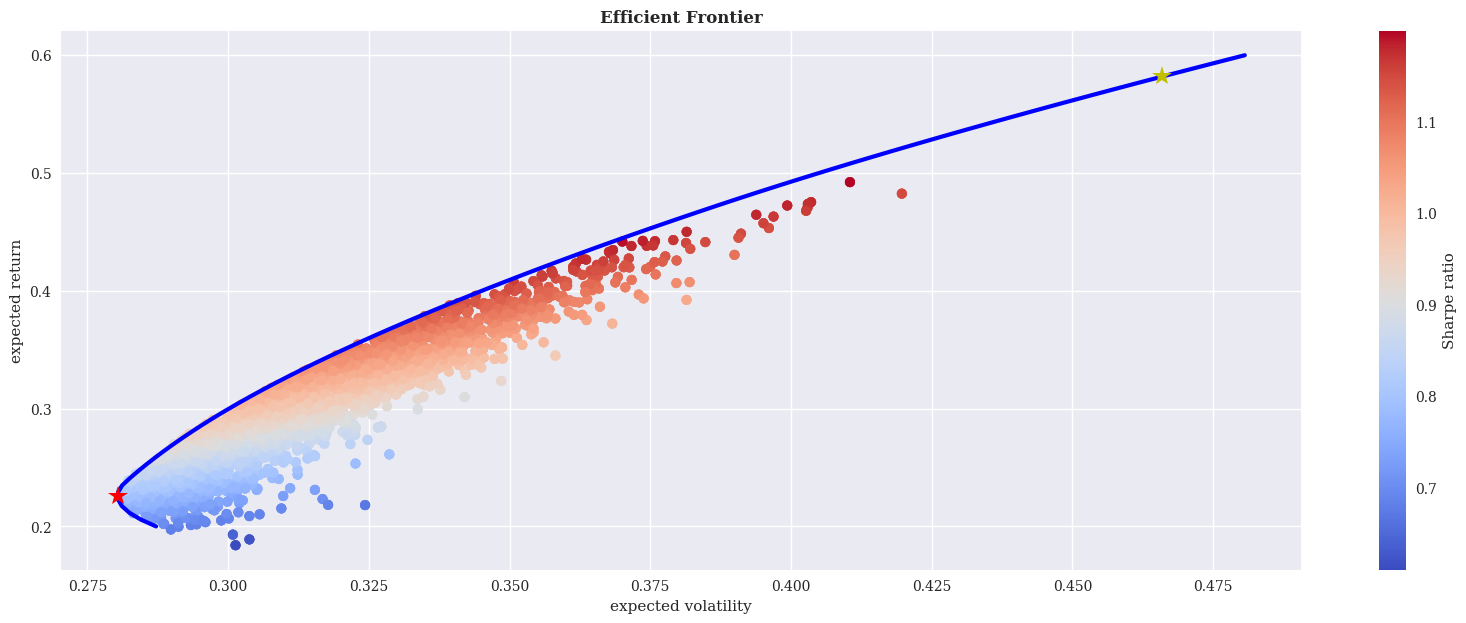

In [17]:
# Efficient Frontier
plt.scatter(port_vol, port_returns, c=port_returns / port_vol,
marker='o', cmap='coolwarm')
plt.scatter(port_vol ,port_returns, c = port_returns / port_vol, cmap = 'coolwarm')
plt.plot(tvols, trets, 'b', lw = 3.0)
plt.plot(port_var(opt_sharpe['x']), port_mean(opt_sharpe['x']), 'y*', markersize = '15.0')
plt.plot(port_var(opt_vol['x']), port_mean(opt_vol['x']), 'r*', markersize = '15.0')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.title('Efficient Frontier', fontweight = 'bold')
plt.colorbar(label='Sharpe ratio');

# **What if investors are allowed to take short positions on stocks?**
In the above exampl, we assume that investors only take long positions in stocks. However, this is not true in real-life situations where investors can also take short positions. Now, we are going to implement MPT theory in a scenario where investors can take both long and short positions in stocks.

**Max sharpe ratio**

In [18]:
returns_data = returns.copy()
dates = data['Date']

In [19]:
# Constraints and bounds
cons11 = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds11 = tuple((-1, 1) for x in range(noa))

# Optimization
opt_sharpe1 = sco.minimize(max_sharpe, eweights, method = 'SLSQP', bounds = bnds11, constraints = cons11)

# Weighted values and sharpe ratio:
print('The weighted value is:', opt_sharpe1['x'])
print('Sharpe ratio for this portfolio is:', port_mean(opt_sharpe1['x'] / port_var(opt_sharpe1['x'])))

The weighted value is: [ 0.78477379 -0.56927633  0.05319014 -0.2686876   1.        ]
Sharpe ratio for this portfolio is: 1.3306354165626177


In [20]:
# Weighted values
max_sharpe_w1 = opt_sharpe1['x']

# Weighted daily returns
msreturns1 = returns.dropna() * max_sharpe_w1
daily_PnL = msreturns1.sum(axis = 1)

# Cumulative PnL
returns_data['max_sharpe_Pnl_1'] = (1 + daily_PnL).cumprod() - 1

**Minimum volatility**

In [21]:
# Optimization
opt_vol1 = sco.minimize(port_var, eweights, method = 'SLSQP', bounds = bnds11, constraints = cons11)

# Weighted values and volatility:
print('The weighted value is:', opt_vol1['x'])
print('The volatility for this portfolio is:', port_var(opt_vol1['x']))

The weighted value is: [ 0.33728118  0.17235159  0.2686762   0.42064564 -0.19895461]
The volatility for this portfolio is: 0.2699220861482554


In [22]:
# Weighted values
min_vol_w1 = opt_vol1['x']

# Weighted daily returns
wdreturns1 = returns.dropna() * min_vol_w1
daily_PnL = wdreturns1.sum(axis = 1)

# Cumulative PnL
returns_data['min_vol_Pnl_1'] = (1 + daily_PnL).cumprod() - 1

# **Profit and Loss (PnL)**
Now we will compare the PnL for the two cases of portfolios.

**Minimum volatitlity portfolio PnL**

In [23]:
# Weighted values
min_vol_w = opt_vol['x']

# Weighted daily returns
pvreturns = returns.dropna() * min_vol_w
daily_PnL = pvreturns.sum(axis = 1)

# Cumulative PnL
returns_data['min_vol_Pnl'] = (1 + daily_PnL).cumprod() - 1

**Maximum sharpe ratio portfolio PnL**

In [24]:
# Weighted values
max_sharpe_w = opt_sharpe['x']

# Weighted daily returns
msreturns = returns.dropna() * max_sharpe_w
daily_PnL = msreturns.sum(axis = 1)

# Cumulative PnL
returns_data['max_sharpe_Pnl'] = (1 + daily_PnL).cumprod() - 1

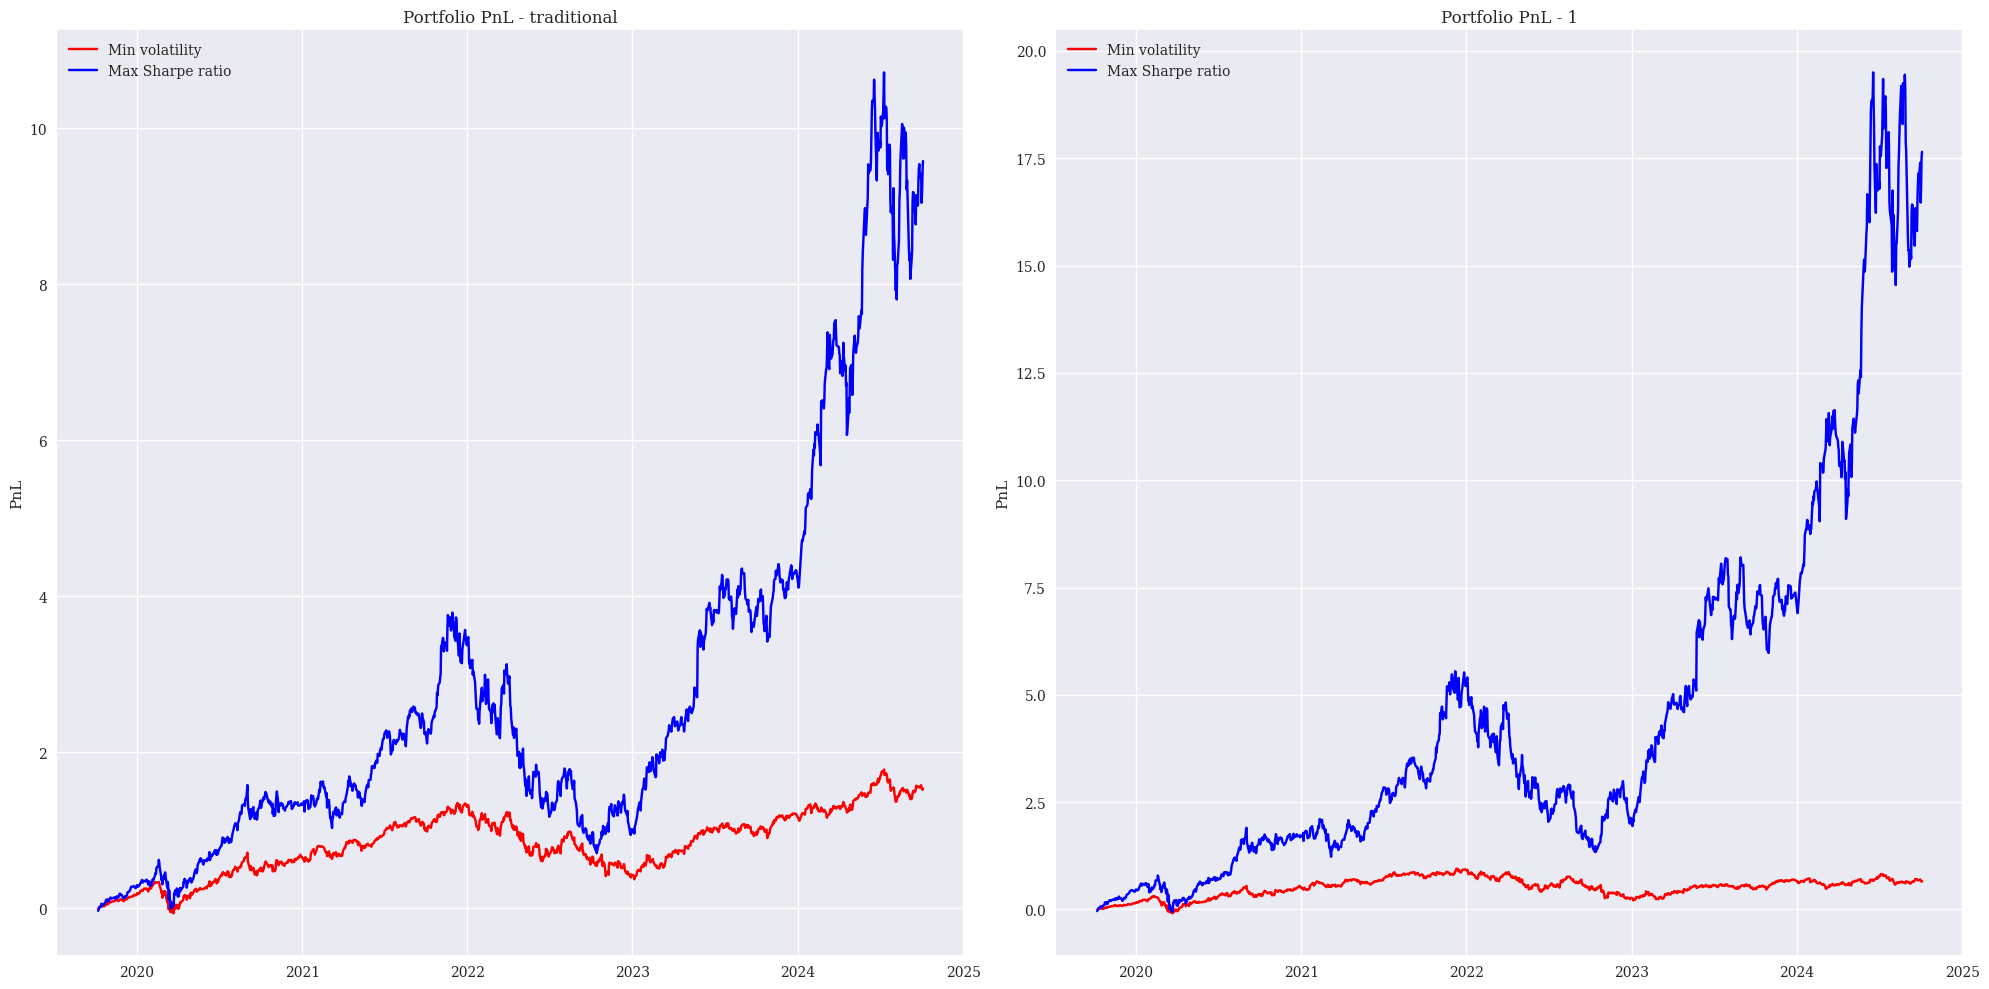

In [25]:
# Comparison between 2 cases
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 1 hàng, 2 cột

# First chart
axs[0].plot(dates, returns_data['min_vol_Pnl'], label='Min volatility', color='r')
axs[0].plot(dates, returns_data['max_sharpe_Pnl'], label='Max Sharpe ratio', color='b')
axs[0].set_ylabel('PnL')
axs[0].set_title('Portfolio PnL - traditional')
axs[0].legend()

# Second chart
axs[1].plot(dates, returns_data['min_vol_Pnl_1'], label='Min volatility', color='r')
axs[1].plot(dates, returns_data['max_sharpe_Pnl_1'], label='Max Sharpe ratio', color='b')
axs[1].set_ylabel('PnL')
axs[1].set_title('Portfolio PnL - 1')
axs[1].legend()

# Plot show
plt.tight_layout()
plt.show()